# AIDM 7380 Group Project<br>
**Dataset**: News Website<br>
**Group Name**: RecomGenius<br>
**Group Member**: <br>
     LIU JIAXIN 23433698 (leader)<br>
     ZHOU YIFAN 23467312<br>
     LUO FAN 23435968<br>
     QIAN CHENGFENG 23467223<br>
     ZHANG ZHENGYI 23467266<br>
     

In [ ]:
# Install NetworkX, Matplotlib, Pandas, Numpy using pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy

In [ ]:
from google.colab import drive
drivePath = '/content/drive' #please do not change
drive.mount(drivePath)

Mounted at /content/drive


In [ ]:
# Import the library
import os, pathlib

# create the file path
dataPath = drivePath + '/MyDrive/Colab Notebooks/data/'
fileName = 'news_dataset1.csv'
filePath = dataPath + fileName

#Create path if not exists
if not(os.path.exists(filePath)):
  path = pathlib.Path(filePath)
  path.mkdir(parents=True, exist_ok=True)
else:
  print('The data path you selected already exists')

# Print the file name including the local path
print(filePath)

The data path you selected already exists
/content/drive/MyDrive/Colab Notebooks/data/news_dataset1.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
%matplotlib inline

In [ ]:
evidence = pd.read_csv(filePath)

In [ ]:
# checkin the type and take a glance at the head
print(type(evidence))
evidence.head(5)

<class 'pandas.core.frame.DataFrame'>


,Date,UserID,ContentID,Event
0,2022-01-10 10:11:36,2786,1624,read
1,2022-01-10 10:11:57,2786,1624,read_more
2,2022-01-10 10:11:57,2469,101,read
3,2022-01-10 10:12:24,2786,1624,author
4,2022-01-10 10:12:26,2033,1984,read


## Data exploration and analysis

In [ ]:
# View basic information about the data
evidence.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286237 entries, 0 to 286236
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Date       286237 non-null  object
 1   UserID     286237 non-null  int64 
 2   ContentID  286237 non-null  int64 
 3   Event      286237 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.7+ MB


In [ ]:
# Get a list of unique user IDs, get a list of unique product IDs
users = evidence.UserID.unique()
content = evidence.ContentID.unique()
print(type(content))
print(len(users))
print(len(content))

<class 'numpy.ndarray'>
5000
1973


Getting the list of users and contents, we can see that there are 5000 different users and 1973 different news contents.

Attempts to visualise relevant data

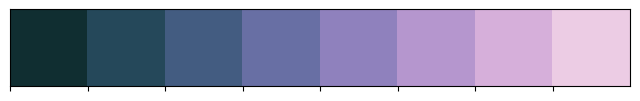

In [ ]:
# Setting the seaborn palette
sns.palplot(sns.cubehelix_palette(8, start=-.75, rot=.5, reverse=True))

In [ ]:
# Set the style of the diagram to a white background with grid lines
sns.set_style("darkgrid")

## Frequency Distribution of Event Types.
In our dataset, there are 5 types of user behaviors(`read` `read_more` `author` `category` `read_comments`) that represent the different degrees of engagement between users and the News Website.

In [ ]:
eventList = evidence.Event.unique()
print(eventList)

['read' 'read_more' 'author' 'category' 'read_comments']


<ipython-input-9-abf703bbfc65>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=event_counts.index, y=event_counts.values, palette=sns.cubehelix_palette(8, start=-.75, rot=.5, reverse=True))
<ipython-input-9-abf703bbfc65>:6: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.barplot(x=event_counts.index, y=event_counts.values, palette=sns.cubehelix_palette(8, start=-.75, rot=.5, reverse=True))


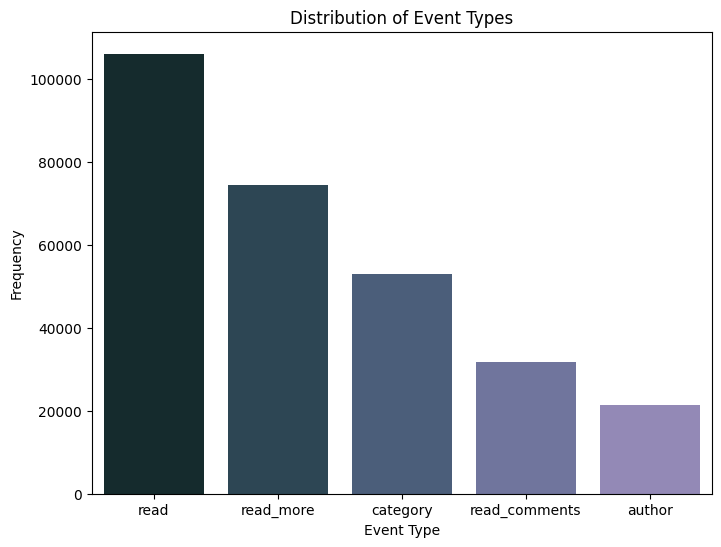

In [ ]:
# Calculate event type frequency
event_counts = evidence['Event'].value_counts()

# draw the distribution of Event Types
plt.figure(figsize=(8, 6))
sns.barplot(x=event_counts.index, y=event_counts.values, palette=sns.cubehelix_palette(8, start=-.75, rot=.5, reverse=True))
plt.xlabel('Event Type')
plt.ylabel('Frequency')
plt.title('Distribution of Event Types')
plt.show()

It can be found that according to the user's degree of interest in the news, in descending order: read -> read_more -> category -> read_comments -> author, which can bring some enlightenment for us to understand the behavior of users/readers and set the proper weight to each of them.

# 1.User-based Collaborative Filtering

In [ ]:
#Create a user-item binary matrix
uiMatrix = pd.DataFrame(columns=content, index=users)
uiMatrix.head(2)

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
2786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Get the Event list and check its contents

In [ ]:
eventList = evidence.Event.unique()
print(eventList)

['read' 'read_more' 'author' 'category' 'read_comments']


## a. Set the Behavioural Implicit Ratings

Give a weight to each event

In [ ]:
eventWeights = {
    'read': 0,
    'read_more': 20,
    'author': 80,
    'category': 50,
    'read_comments': 100}

**Weight Setting**: According to the layout of normal news websites,we give `read` a weight of 0, which represents that users only look at the cover or thumbnail of the news report, and `read_more` represents that users click the news or expand the news page for more detail, hence we give it a higher weight 20. On a general expanded news report page, the `category` column is often placed at the top of the page, while the `author` is usually located below the news title. Therefore, we infer that the `author` has a higher weight than the `category` based on the position. If the user clicks the author button, we infer that he/she has at least browsed the news title or scrolled up and down to read part of the news content, and wants to see other works of the author. If the user directly clicks the other `category` button at the top, then the user is likely to have lost interest in this article and wants to find other news. Based on this, we gave the `category` a weight of 50 and gave the `author` a higher weight of 80. About the `read_comments`, comment section is always located at the bottom of the news webpage, if users take the operation of reading comments, which means he/she might has read whole page of news report, so we give it the highest weight of 100 among these 5 operations.

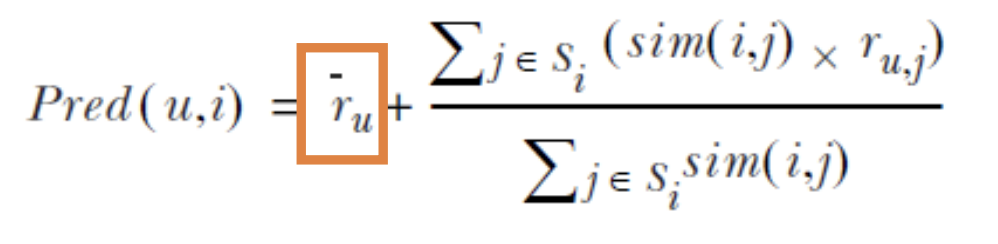Compute the Implicit Rating for each user-item combination.
Populate the user-item matrix `uiMatrix` with the IR values.

Using the formula introduced during lecture

$${IR}_(i,u) = \left(w_1*{\#event}_1\right)+\left(w_2*{\#event}_2\right)+\dots+\left(w_n*{\#event}_n\right)$$

In [ ]:
# Iterate the evidence
for index, row in evidence.iterrows():
    # Select the user and items involved
    currentUser = row['UserID']
    currentContent = row['ContentID']

    # Extract the appropriate weight for the event
    w = eventWeights[row['Event']] # w is weight

    # Find the value eventually stored for the current user-item combination
    currentValue = uiMatrix.at[currentUser, currentContent]
    if np.isnan(currentValue):
        currentValue = 0

    # Compute the new value and update the user-item matrix
    updatedValue = currentValue + w #+ (1 * w)
    uiMatrix.at[currentUser, currentContent] = updatedValue

## b. Normalise the Matrix
Update the user-item matrix by normalizing the values between 0 and 10.


Encapsulating a Normalised Function.

In [ ]:
def normalizeUiMatrix(uiMatrix):
  # Fill the NaN value with the minimum value fisrt
  uiMatrix_filled = uiMatrix.fillna(uiMatrix.min().min())

  # Calculate the minimum and maximum values in a matrix
  min_value = np.nanmin(uiMatrix)
  max_value = np.nanmax(uiMatrix)

  # Perform max-min normalisation
  # Subtract the minimum value to get a new matrix that makes the minimum value 0
  # Calculate the difference between the maximum and minimum values to get a normalised range
  # Divide by the normalised range to get the normalised matrix such that the maximum value becomes 1 and the minimum value becomes 0
  # Multiply the normalised matrix by 10
  uiMatrix_filled_normalized = ((uiMatrix - min_value) / (max_value - min_value)) * 10

  # Reset the NaN value back
  uiMatrix_normalized = uiMatrix_filled_normalized.where(uiMatrix.notna())
  return uiMatrix_normalized

In [ ]:
uiMatrix_normalized = normalizeUiMatrix(uiMatrix)
uiMatrix_normalized.head()

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
2786,3.571429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,NaN,1.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,NaN,NaN,1.666667,NaN,1.666667,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1695,NaN,NaN,NaN,1.190476,NaN,NaN,1.190476,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1359,NaN,NaN,NaN,NaN,3.095238,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## c. Demonstration 1: Consider Events Only
At first, we only want to take user evnts into consideration and try to design the function `userCF_prediction(df, currentUser, numUsers, numItems)` where the parametes are:
- `df` is a dataframe containing the user-item ratings
- `currentUser` is the user for which we want to predict the ratings
- `numUsers` is the number of users we want to use to compute the predicted ratings
- `numItems` is the number of items we want to return for suggesting to the current user

In [ ]:
def userCF_prediction(df, currentUser, numUsers, numItems):
  # Converting all the values in the matrix as floating point numbers
  # Converting currentUser as int
  df = df.astype(float)
  # Select the current user list of news in a Pandas Series
  cuDf = df.loc[currentUser]

  # Compute correlation using corrwith
  corrDf = df.corrwith(cuDf, axis=1, method='pearson') # Calculation using Pearson's correlation coefficient

  # Sort the values
  corrDf.sort_values(ascending=False, inplace=True)
  # Drop the currentUser itself
  corrDf.drop(labels=[currentUser], inplace=True)

  # Select the number of users
  corrDf = corrDf.head(numUsers)

  # Select the items whose values are to be predicted for current user
  toPredict = cuDf[cuDf.isna()]
  # Select all the ratings from the other users selected for rating prediction
  ratings = df.loc[corrDf.index]
  # Select their ratings for the items
  ratingsToPredict = ratings[toPredict.index]
  # Compute the predicted ratings for current user.
  predictedRatings = ratingsToPredict.mean()
  predictedRatings.sort_values(ascending=False, inplace=True)

  # Select the top-k for recommendation.
  topK = predictedRatings.head(numItems)
  return topK

 Here, we want to predict the reading taste of user whoes id is 2786. We set the number of similar users used to calculate the prediction to 2, and return 5 news as recommendations.

In [ ]:
userCF_prediction(uiMatrix_normalized, 2786, 2, 5)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


559     5.952381
1502    4.047619
1117    4.047619
1959    4.047619
1076    4.047619
dtype: float64

##d .Evaluation of the performance

### (1).User Coverage
Iterate over all users and check if each user has at least one recommendation.

Since the matrix numbers are so large that using the original prediction function would make the computation time required to calculate user coverage too long, we chose to design a function specifically for calculating user coverage based on the following points.

Reprocessing the user-commodity matrix:

1. There is no need to calculate exact predictive ratings. You stop the calculation as soon as you find a sufficient number of similar users who have already rated items that the user has not rated.

2. Operations on a DataFrame can be slow when dealing with large-scale data. I chose to convert the data into NumPy arrays for the calculations.

3. If there is a rating, then at least one item can be predicted, which means that the recommender system reaches this user, and can be returned directly.

In [ ]:
import numpy as np

def userCF_prediction_simple(df, currentUser, numUsers):
    # Select current user rating
    cuDf = df.loc[currentUser]

    # Check if the user similarity matrix has been pre-calculated
    if 'user_similarity' not in globals():
        global user_similarity
        user_similarity = df.T.corr(method='pearson')

    # Get the first numUsers of the most similar users.
    top_users = user_similarity[currentUser].drop(labels=[currentUser]).nlargest(numUsers)

    # Get items that have not been rated by the current user
    items_to_predict = cuDf[cuDf.isna()].index

    # Get ratings on these items from similar users
    ratings_of_similar_users = df.loc[top_users.index, items_to_predict]

    # Check for scoring of predicted items
    if ratings_of_similar_users.notna().any().any():
        # If there is a score, then at least one item can be predicted, which is all the information we need to calculate coverage
        return True

    return False

In [ ]:
def calculate_user_coverage(df, numUsers):
    # of users calculated to be able to recommend at least one item for them
    num_users_with_recommendations = 0

    # Iterate over each user
    for currentUser in df.index:
        # Check if at least one item can be recommended for this user
        if userCF_prediction_simple(df, currentUser, numUsers):
            num_users_with_recommendations += 1

    # Calculate user coverage
    user_coverage_rate = num_users_with_recommendations / len(df.index)

    return user_coverage_rate

# Assume df is your user-item scoring matrix and numUsers is the number of similar users you wish to consider
# Call the function to calculate the user coverage
coverage_rate = calculate_user_coverage(uiMatrix_normalized, 2)

print(f"User coverage is: {coverage_rate:.2%}")

User coverage is: 100.00%


You can see that the user coverage is one hundred percent, which means that each user can be recommended at least one news.

### (2).Catalogue Coverage
Considering that the user-item matrix is large, I chose to redesign the function to calculate catalogue coverage

In [ ]:
def userCF_prediction_simple02(df, currentUser, numUsers, numItems):

  # Select the current user list of news in a Pandas Series
  cuDf = df.loc[currentUser]

  # Compute correlation using corrwith
  corrDf = df.corrwith(cuDf, axis=1, method='pearson') # Calculation using Pearson's correlation coefficient

  # Sort the values
  corrDf.sort_values(ascending=False, inplace=True)
  # Drop the currentUser itself
  corrDf.drop(labels=[currentUser], inplace=True)

  # Select the number of users
  corrDf = corrDf.head(numUsers)

  # Select the items whose values are to be predicted for current user
  toPredict = cuDf[cuDf.isna()]
  # Select all the ratings from the other users selected for rating prediction
  ratings = df.loc[corrDf.index]
  # Select their ratings for the items
  ratingsToPredict = ratings[toPredict.index]
  # Compute the predicted ratings for current user.
  predictedRatings = ratingsToPredict.mean()
  predictedRatings.sort_values(ascending=False, inplace=True)

  # Select the top-k for recommendation.
  topK = predictedRatings.head(numItems)
  return topK

# Make sure the matrix is normalized before passing it to the function
uiMatrix_normalized = uiMatrix_normalized.astype(float)

In [ ]:
def calculate_item_coverage(df, numUsers, numItems):
    # Stores a collection of all recommended products
    recommended_items = set()

    # Iterate over all users
    for currentUser in df.index:
        # Generate recommendations for the current user
        topK = userCF_prediction_simple02(df, currentUser, numUsers, numItems)

        # Add recommended products to the collection
        recommended_items.update(topK.index)

    # Calculate product recommendation coverage
    item_coverage_rate = len(recommended_items) / df.shape[1]

    return item_coverage_rate


# Call the function to calculate the product recommendation coverage
coverage_rate = calculate_item_coverage(uiMatrix_normalized, 2, 5)

print(f"Catalogue recommendation coverage is: {coverage_rate:.2%}")

流式输出内容被截断，只能显示最后 5000 行内容。
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3

Catalogue recommendation coverage is: 95.34%


You can see that the catalogue coverage is 95.34%, which means that the majority of the films are recommended to users, and about 5% of the news are not recommended to any user, which are likely to have cold subjects and poor ratings.

## d. Demonstration 2: Consider Events with Time Decay
Considering that earlier events do not provide much useful information about user behaviour, we try to use decay to adjust the recommendation system.

It can be seen that the introduction of the decay factor increases the diversity of recommendations (Before the introduction of the decay factor, the similarity of the recommended news Id of 1502, 1117, 1959 and 1076 is 4.047619, which means that the diversity of the recommendations is low) which helps us to successfully reduce the dependency on the user's historical behaviour.

Behavioural Implicit Ratings with Decay

$${IRDecay}_{(i,u)} = \sum_{i=1}^n w_i*{\#event}_i*d\left({\#event}_i\right) = \left(w_1*{\#event}_1*d\left({\#event}_1\right)\right)+\left(w_2*{\#event}_2*d\left({\#event}_2\right)\right)+\dots+\left(w_n*{\#event}_n*d\left({\#event}_n\right)\right)$$

Compute the `decayFactor`

In [ ]:
import datetime
from datetime import date, timedelta, datetime

def compute_decay(eventDate, decayDays):
    age = (date.today() - datetime.strptime(eventDate, '%Y-%m-%d %H:%M:%S').date()) // timedelta(days=decayDays)
    #print("Age of event:", age)
    decay = 1/age #simple decay
    #print("Decay factor:", decay)

    return decay

createdEvent = evidence.at[0,'Date']
thresholdDays = 2 # Number of days
decayFactor = compute_decay(createdEvent, thresholdDays)

print(decayFactor)

0.0024271844660194173


In [ ]:
#Create a user-item binary matrix
uiMatrix = pd.DataFrame(columns=content, index=users)
uiMatrix.head(2)

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
2786,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Get a new `uiMatrix` with time decay

In [ ]:
for index, row in evidence.iterrows():
    # Select the user and items involved
    currentUser = row['UserID']
    currentContent = row['ContentID']

    currentEvent = row['Event']
    createdEvent = row['Date']

    # Calculating d
    decayFactor = compute_decay(createdEvent, thresholdDays)
    # Extract the appropriate weight for the event
    w = eventWeights[row['Event']] * decayFactor

    # Find the value eventually stored for the current user-item combination
    currentValue = uiMatrix.at[currentUser, currentContent]
    if np.isnan(currentValue):
          currentValue = 0
    # Compute the new value and update the user-item matrix
    updatedValue = currentValue + w #+ (1 * w)

    uiMatrix.at[currentUser, currentContent] = updatedValue

In [ ]:
uiMatrix.head()

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
2786,0.364078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,NaN,0.169903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,NaN,NaN,0.169903,NaN,0.174129,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1695,NaN,NaN,NaN,0.121359,NaN,NaN,0.125945,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1359,NaN,NaN,NaN,NaN,0.315534,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
uiMatrix_normalized = normalizeUiMatrix(uiMatrix)
uiMatrix_normalized.head()

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
2786,3.433495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,NaN,1.602298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,NaN,NaN,1.602298,NaN,1.642156,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1695,NaN,NaN,NaN,1.144498,NaN,NaN,1.187742,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1359,NaN,NaN,NaN,NaN,2.975696,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
result = userCF_prediction(uiMatrix, 2786, 2, 5)
print(result)
print('Avg:',result.mean())

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


1562    0.589744
1351    0.456853
1925    0.434783
268     0.432570
207     0.423940
dtype: float64
Avg: 0.46757782289961136


## e. Tuning 1: Take More Neighbors into Consideration and Exclude Less Relevant Contents
Due to we are using User-based collaborative filtering now, we should pay more attention to the similar users. And we want to see if we take more neighbors into accout and exclude less relevant contents, will we get better news recommendations. Therefore, we try to set different `numUsers` and `numItems` to see the results.

Here we use average similarity of the recommendations to evaluate the recommend quality.

In [ ]:
results_df = pd.DataFrame(columns=['Parameters', 'Avg'])

# set different numUsers and numItems
parameters = [(3, 5), (3, 3), (5, 5), (5, 3), (7, 5), (7, 3)]

for i, param in enumerate(parameters):
    result = userCF_prediction(uiMatrix, 2786, *param)
    avg = result.mean()
    results_df.loc[i] = [param, avg]

results_df

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.10/dist-packages/numpy/lib

,Parameters,Avg
0,"(3, 5)",0.485051
1,"(3, 3)",0.518933
2,"(5, 5)",0.540081
3,"(5, 3)",0.577783
4,"(7, 5)",0.540081
5,"(7, 3)",0.577783


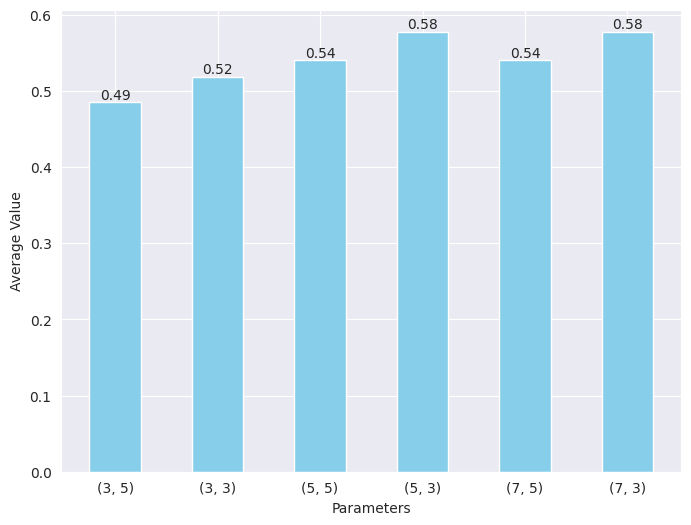

In [ ]:
param_labels = [str(param) for param in parameters]

plt.figure(figsize=(8, 6))
bars = plt.bar(range(len(results_df)), results_df['Avg'], color='skyblue', width=0.5)
plt.xticks(range(len(results_df)), param_labels)
plt.xlabel('Parameters')
plt.ylabel('Average Value')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

plt.show()

In [ ]:
# decide to use (5, 3)
result = userCF_prediction(uiMatrix, 2786, 5, 3)
print(result)
print('Avg:',result.mean())

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


559     0.628141
1562    0.589744
1874    0.515464
dtype: float64
Avg: 0.5777827369289835


According to the above results, we decide to increase the amount of neighbors from 2 to 5 and decrease the amount of top-k news from 5 to 3, to achieve a better overall recommendation performance (average similarity of the recommendations increased from **0.468** to **0.578**). <br>

In conlusion, when we use User-based CF, for our current user 2786, the top 3 news the system may recommend are news 559, news 1562 and news 1874, just as the `result` shows above.

# 2.Item-based Collaborative Filtering

Base on the uiMatrixNorm that has taken the operations of normalized and using the decay,we directly take next operations on this matrix.

In [ ]:
uiMatrixNorm = uiMatrix_normalized.astype(float)

In [ ]:
uiMatrixNorm.head(5)

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
2786,3.433495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,NaN,1.602298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,NaN,NaN,1.602298,NaN,1.642156,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1695,NaN,NaN,NaN,1.144498,NaN,NaN,1.187742,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1359,NaN,NaN,NaN,NaN,2.975696,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## a. Check the Sparsity of the Matrix
The sparsity of matrix is quite high

In [ ]:
# Compute sparsity value of the matrix

# Number of possible ratings
matrixSize = uiMatrixNorm.shape[0]*uiMatrixNorm.shape[1]

# Number of na elements
matrixNA = uiMatrixNorm.isna().sum().sum()

# Sparsity value
uiMatrixSparsity = matrixNA / matrixSize
uiMatrixSparsity

0.9892797769893563

## b. Similarity Precomputation

Convert to boolean matrix

In [ ]:
def to_bool(value):
    if np.isnan(value):
        return 0
    else:
        return 1

In [ ]:
uiMatrixBool = uiMatrixNorm.applymap(lambda x: to_bool(x))
uiMatrixBool

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
2786,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2469,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2033,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1695,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1359,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4619,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
uiMatrixBool.T

,2786,2469,2033,1695,1359,1955,1364,3086,3667,633,...,1838,4051,2281,4969,4419,4619,867,116,1542,4834
1624,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
101,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1984,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
801,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
222,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##c. Multiply Item * Item By Using 'Dot' Function
To find the number of co-ratings

In [ ]:
overlappingUsersRatings = uiMatrixBool.T.dot(uiMatrixBool)#A*AT
overlappingUsersRatings

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
1624,73,2,2,0,1,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
101,2,51,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1984,2,1,93,0,3,1,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
801,0,1,0,50,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,1,1,3,1,81,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1617,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,0


In [ ]:
overlappingUsersRatings.shape

(1973, 1973)

In [ ]:
overlappingUsersRatings.head(10)

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
1624,73,2,2,0,1,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
101,2,51,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1984,2,1,93,0,3,1,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
801,0,1,0,50,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,1,1,3,1,81,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
987,0,1,1,1,1,57,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
381,0,0,1,1,0,1,55,1,0,2,...,0,0,0,0,0,0,0,0,0,0
762,1,0,2,0,1,0,1,45,0,0,...,0,0,0,0,0,0,0,0,0,0
1788,0,0,0,0,1,1,0,0,28,1,...,0,0,0,0,0,0,0,0,0,0
1869,0,1,2,0,1,1,2,0,1,60,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
overlappingUsersRatings.max(axis=0).max()

119

In [ ]:
overlappingUsersRatings.min(axis=0).min()#have no overlap with other contents

0

Our sparsity is around 98.9%, which is quite high. Almost every content's min `overlappingUsersRatings` is 0, which means that if we set threshold more than 0, everything will be dropped and we will not enable to compute the item-item similarity matrix in next, so we set it to be 0 and compute similarities between all 1973 items.

In [ ]:
toDrop = overlappingUsersRatings.min(axis=0) >= 0
toDrop.head(10)

1624    True
101     True
1984    True
801     True
222     True
987     True
381     True
762     True
1788    True
1869    True
dtype: bool

In [ ]:
Ture_count = sum(1 for item in toDrop if item == True)
Ture_count

1973

In [ ]:
selectedItems = overlappingUsersRatings.loc[toDrop, toDrop]
selectedItems.head(5)

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
1624,73,2,2,0,1,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
101,2,51,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1984,2,1,93,0,3,1,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
801,0,1,0,50,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
222,1,1,3,1,81,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
selectedIndex = selectedItems.index#list of item
selectedIndex

Index([1624,  101, 1984,  801,  222,  987,  381,  762, 1788, 1869,
       ...
       1718,    6, 1072,  957,  415,  900,  769, 1617,  534,  442],
      dtype='int64', length=1973)

In [ ]:
uiMatrixSelection = uiMatrixNorm[selectedIndex]
uiMatrixSelection

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
2786,3.433495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,NaN,1.602298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,NaN,NaN,1.602298,NaN,1.642156,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1695,NaN,NaN,NaN,1.144498,NaN,NaN,1.187742,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1359,NaN,NaN,NaN,NaN,2.975696,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4619,3.683855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
uiMatrixSelection = uiMatrixSelection.sub(uiMatrixSelection.mean(axis=1), axis=0)#adjusted rating
uiMatrixSelection

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
2786,0.990830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2469,NaN,-0.601826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2033,NaN,NaN,-0.203935,NaN,-0.164077,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1695,NaN,NaN,NaN,-1.100493,NaN,NaN,-1.05725,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1359,NaN,NaN,NaN,NaN,1.119889,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4619,1.081803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##d. Create the Item-to-Item Similarity Matrix

In [ ]:
iiSimMatrix = pd.DataFrame().reindex_like(selectedItems)
iiSimMatrix.head(5)

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
1624,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from scipy.spatial.distance import cosine
import pandas as pd

def cosine_sim(df1, df2):
    # Create masks for non-NA values in both series
    mask = ~df1.isna() & ~df2.isna()

    # Apply the mask to get the ratings present in both series
    df1clean = df1[mask]
    df2clean = df2[mask]

    # If either of the cleaned series are empty, return 0 as the similarity
    if df1clean.empty or df2clean.empty:
        return 0

    # Compute cosine similarity
    distance = cosine(df1clean, df2clean)
    sim = 1 - distance

    return sim

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Convert the DataFrame to a NumPy array, filling NA values with zeros.
ui_matrix_np = np.nan_to_num(uiMatrixSelection.to_numpy())

# Compute the cosine similarity matrix using sklearn (this handles the dense input).
similarity_matrix = cosine_similarity(ui_matrix_np.T)  # Transpose to get item-item similarity

# Convert the similarity matrix back to a DataFrame (with items as both rows and columns).
iiSimMatrix = pd.DataFrame(similarity_matrix, index=uiMatrixSelection.columns, columns=uiMatrixSelection.columns)
iiSimMatrix

,1624,101,1984,801,222,987,381,762,1788,1869,...,1718,6,1072,957,415,900,769,1617,534,442
1624,1.000000,0.043026,-0.000226,0.000000,0.006829,0.000000,0.000000,0.001138,0.000000,0.000000,...,0.0,-0.004195,0.055513,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.043026,1.000000,0.002062,0.003174,-0.000405,-0.010632,0.000000,0.000000,0.000000,-0.014894,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,-0.000226,0.002062,1.000000,0.000000,0.052577,0.010712,-0.009645,-0.016291,0.000000,0.005880,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
801,0.000000,0.003174,0.000000,1.000000,-0.042078,0.007757,0.011382,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
222,0.006829,-0.000405,0.052577,-0.042078,1.000000,-0.010793,0.000000,0.021848,-0.011771,-0.000595,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
769,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
534,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## e. Recommend the Top-k Items to the User
Very simple to create a list of similar items, we already found out the similarity in previous steps.

In [ ]:
#we set user 2786 as our showcase
currentUser = 2786

In [ ]:
def itemCF_precomputed(similarityMatrix, currentItem, numItems):
    #Select current item from the similarity matrix, remove not rated items, sort the values and select the top-k items
    recommendationList = similarityMatrix[currentItem].dropna().sort_values(ascending=False).head(numItems)
    # Exclude the currentItem from the recommendationList
    recommendationList = recommendationList[recommendationList.index != currentItem]
    return recommendationList.index.to_list()

The userID is not really needed for recommendation, we will use it to choose an item that the user rated and we want to find similar items.

In [ ]:
cuRatedItems = uiMatrixSelection.loc[2786].dropna().sort_values(ascending=False)
cuRatedItems.head()

977     3.526112
1611    1.743271
530     1.565369
307     1.467612
700     1.222102
Name: 2786, dtype: float64

We choose item 977 as compared item to current item

In [ ]:
itemCF_precomputed(iiSimMatrix, 977, 3)

[292, 815, 992]

We calculate the predicted rating according to this formula.

<table class="image">
<tr><td><img src="https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781617292705/files/OEBPS/Images/p0198_01.jpg" alt="drawing" width="450"/></td></tr>
<caption align="center">Prediction calculation</caption>
<td><img src="https://learning.oreilly.com/api/v2/epubs/urn:orm:book:9781617292705/files/OEBPS/Images/p0198_02.jpg"/>  is the average rating of the user u</td>
</table>

*    $r_{u,j}$  is the active user's rating of item j
*    $s_i$  is the set of items in the neighborhood that user u has rated
*   Pred(u,i) is the predicted rating for user u of item i
*   sim(i,j) is the similarity between item i and item j







In [ ]:
def itemCF_prediction(df, currentUser, currentItem):
    uiMatrixCurrentUser = df.loc[[currentUser]]
    uiMatrixCurrentUser = uiMatrixCurrentUser.dropna(axis = 1)
    uiMatrixCurrentUser = uiMatrixCurrentUser.sub(uiMatrixCurrentUser.mean(axis=1), axis=0)#r-r(avg)

    item_row = iiSimMatrix.loc[currentItem]

# Filter the items in the row based on whether they are present in the user-item matrix and are rated by the user
    rated_items = item_row.index.intersection(uiMatrixCurrentUser.columns)
    rated_items = rated_items[rated_items.isin(uiMatrixCurrentUser.columns)]

# Sort the items in the row by similarity and select the top 3
    top_3_items = item_row[rated_items].nlargest(3)
    user_ratings = uiMatrixCurrentUser.loc[:, top_3_items.index]
    weighted_ratings = top_3_items * user_ratings.loc[currentUser]
    sum_weighted_ratings = weighted_ratings.sum()
    sum_weighted_ratings

    cuAvgRating = uiMatrixNorm.loc[[currentUser]].dropna(axis=1).mean(axis=1)
    forCalculate = sum_weighted_ratings/top_3_items.sum()
    forCalculate += cuAvgRating.iloc[0]

    return forCalculate

In [ ]:
itemCF_prediction(uiMatrixNorm, 2786, 292)

1.7143749053900472

In [ ]:
itemCF_prediction(uiMatrixNorm, 2786, 63)

2.3346170103903674

In [ ]:
itemCF_prediction(uiMatrixNorm, 2786, 1886)

2.3346170103903674

In [ ]:
def itemCF_recommender(df,iiSimMatrix,currentUser,numItems):
    cuRatedItems = uiMatrixSelection.loc[currentUser].dropna().sort_values(ascending=False)
    first_item_id = cuRatedItems.index[0]
    itemTocompare = first_item_id
    recommend_list = itemCF_precomputed(iiSimMatrix, itemTocompare, numItems)

    paired_results = []

    for item in recommend_list:
        result = itemCF_prediction(df, currentUser, item)
        paired_results.append((item, result))  # Append a tuple of (element, result)

    paired_results = sorted(paired_results, key=lambda x: x[1], reverse=True)
    return paired_results

By using the itemCF_recommender function we can get the recommended items of user 2786 baseing on the item 977 that the highest item by user rated.

In [ ]:
result = itemCF_recommender(uiMatrixNorm,iiSimMatrix,2786,3)
result

[(815, 3.179825385784692),
 (992, 2.0880999662958293),
 (292, 1.7143749053900472)]

In [ ]:
values = [x[1] for x in result]
total_sum = sum(values)
num_values = len(values)
average = total_sum / num_values
print("Avg:", average)

Avg: 1.6384912259748028


##f .Evaluation of the performance

### (1).User Coverage

In [ ]:
def calculate_user_coverage(df, iiSimMatrix, numItems):
    # Count the number of users who received recommendations
    users_with_recommendations = 0

    # Iterate over all users
    for currentUser in df.index:
        # Generate recommendations for the current user
        topK = itemCF_recommender(df, iiSimMatrix, currentUser, numItems)

        # If the user received at least one recommendation, increment the counter
        if topK:  # Assuming topK is a non-empty list of recommendations
            users_with_recommendations += 1

    # Calculate user coverage as the ratio of users who received recommendations to the total number of users
    user_coverage_rate = users_with_recommendations / len(df.index)

    return user_coverage_rate

# Call the function to calculate the user coverage
user_coverage_rate = calculate_user_coverage(uiMatrix, iiSimMatrix, 3)

print(f"User recommendation coverage is: {user_coverage_rate:.2%}")

User recommendation coverage is: 100.00%


### (2).Catalogue Coverage

In [ ]:
def calculate_catalogue_coverage(df, iiSimMatrix, numItems):
    # Stores a collection of all recommended products
    recommended_items = set()

    # Iterate over all users
    for currentUser in df.index:
        # Generate recommendations for the current user
        topK = itemCF_recommender(df, iiSimMatrix, currentUser, numItems)

        # Add recommended products to the collection if they are not already in the set
        for item, _ in topK:  # Assuming topK returns a list of (item, score) tuples
            recommended_items.add(item)

    # Calculate product recommendation coverage
    total_unique_items = len(iiSimMatrix.columns)  # Assumes iiSimMatrix has all items as columns
    item_coverage_rate = len(recommended_items) / total_unique_items

    return item_coverage_rate

# Call the function to calculate the product recommendation coverage
coverage_rate = calculate_catalogue_coverage(uiMatrixNorm, iiSimMatrix, 3)

print(f"Catalogue recommendation coverage is: {coverage_rate:.2%}")

Catalogue recommendation coverage is: 74.86%


For the catalogue coverage, 74.86% means that not all the news items are enrolled in the recommendation process. It might be the reason that there are some users that have unpopular reading preferences, and these item will not be recommended to other users.

## g. Tunning 2: Take More Neighbor Items into Consideration

As we are now using Item-based Collaborative Filtering, we need to pay more attetion to the similar items. At this time, we still use average similarity of the recommendations to evaluate the recommend quality.



Select the top 5 similar items of `currentItems`, and return 2/3/5 recommendations respectively.



In [ ]:
# Select the top 5 similar items of currentItems
def itemCF_prediction(df, currentUser, currentItem):
    uiMatrixCurrentUser = df.loc[[currentUser]]
    uiMatrixCurrentUser = uiMatrixCurrentUser.dropna(axis = 1)
    uiMatrixCurrentUser = uiMatrixCurrentUser.sub(uiMatrixCurrentUser.mean(axis=1), axis=0)#r-r(avg)

    item_row = iiSimMatrix.loc[currentItem]

# Filter the items in the row based on whether they are present in the user-item matrix and are rated by the user
    rated_items = item_row.index.intersection(uiMatrixCurrentUser.columns)
    rated_items = rated_items[rated_items.isin(uiMatrixCurrentUser.columns)]

# Sort the items in the row by similarity and select the top 5
    top_5_items = item_row[rated_items].nlargest(5)
    user_ratings = uiMatrixCurrentUser.loc[:, top_5_items.index]
    weighted_ratings = top_5_items * user_ratings.loc[currentUser]
    sum_weighted_ratings = weighted_ratings.sum()
    sum_weighted_ratings

    cuAvgRating = uiMatrixNorm.loc[[currentUser]].dropna(axis=1).mean(axis=1)
    forCalculate = sum_weighted_ratings/top_5_items.sum()
    forCalculate += cuAvgRating.iloc[0]

    return forCalculate

In [ ]:
def calculate_average(result):
    values = [x[1] for x in result]
    total_sum = sum(values)
    num_values = len(values)
    return total_sum / num_values

result_1 = itemCF_recommender(uiMatrixNorm, iiSimMatrix, 2786, 2) #return 2 recommendations
average_1 = calculate_average(result_1)

result_2 = itemCF_recommender(uiMatrixNorm, iiSimMatrix, 2786, 3) #return 2 recommendations
average_2 = calculate_average(result_2)

result_3 = itemCF_recommender(uiMatrixNorm, iiSimMatrix, 2786, 5) #return 5 recommendations
average_3 = calculate_average(result_3)

result_data_5 = {
    "Number of Neighbor items": [5, 5, 5],
    "Number of Recommendations": [2, 3, 5],
    "Average of Similarity": [average_1, average_2, average_3]
}

df_5 = pd.DataFrame(result_data_5)

print(df_5)

   Number of Neighbor items  Number of Recommendations  Average of Similarity
0                         5                          2               2.647580
1                         5                          3               2.372963
2                         5                          5               2.648252


Select the top 10 similar items of `currentItems`, and return 2/3/5 recommendations respectively.

In [ ]:
# Select the top 5 similar items of currentItems
def itemCF_prediction(df, currentUser, currentItem):
    uiMatrixCurrentUser = df.loc[[currentUser]]
    uiMatrixCurrentUser = uiMatrixCurrentUser.dropna(axis = 1)
    uiMatrixCurrentUser = uiMatrixCurrentUser.sub(uiMatrixCurrentUser.mean(axis=1), axis=0)#r-r(avg)

    item_row = iiSimMatrix.loc[currentItem]

# Filter the items in the row based on whether they are present in the user-item matrix and are rated by the user
    rated_items = item_row.index.intersection(uiMatrixCurrentUser.columns)
    rated_items = rated_items[rated_items.isin(uiMatrixCurrentUser.columns)]

# Sort the items in the row by similarity and select the top 10
    top_10_items = item_row[rated_items].nlargest(10)
    user_ratings = uiMatrixCurrentUser.loc[:, top_10_items.index]
    weighted_ratings = top_10_items * user_ratings.loc[currentUser]
    sum_weighted_ratings = weighted_ratings.sum()
    sum_weighted_ratings

    cuAvgRating = uiMatrixNorm.loc[[currentUser]].dropna(axis=1).mean(axis=1)
    forCalculate = sum_weighted_ratings/top_10_items.sum()
    forCalculate += cuAvgRating.iloc[0]

    return forCalculate

In [ ]:
result_4 = itemCF_recommender(uiMatrixNorm, iiSimMatrix, 2786, 2) #return 2 recommendations
average_4 = calculate_average(result_4)

result_5 = itemCF_recommender(uiMatrixNorm, iiSimMatrix, 2786, 3) #return 2 recommendations
average_5 = calculate_average(result_5)

result_6 = itemCF_recommender(uiMatrixNorm, iiSimMatrix, 2786, 5) #return 5 recommendations
average_6 = calculate_average(result_6)

result_data_10 = {
    "Number of Neighbor items": [10, 10, 10],
    "Number of Recommendations": [2, 3, 5],
    "Average of Similarity": [average_4, average_5, average_6]
}

df_10 = pd.DataFrame(result_data_10)

print(df_10)

   Number of Neighbor items  Number of Recommendations  Average of Similarity
0                        10                          2               2.276707
1                        10                          3               2.362118
2                        10                          5               2.470720


In [ ]:
df_combined = pd.concat([df_5, df_10], ignore_index=True)
df_combined

,Number of Neighbor items,Number of Recommendations,Average of Similarity
0,5,2,2.647580
1,5,3,2.372963
2,5,5,2.648252
3,10,2,2.276707
4,10,3,2.362118
5,10,5,2.470720


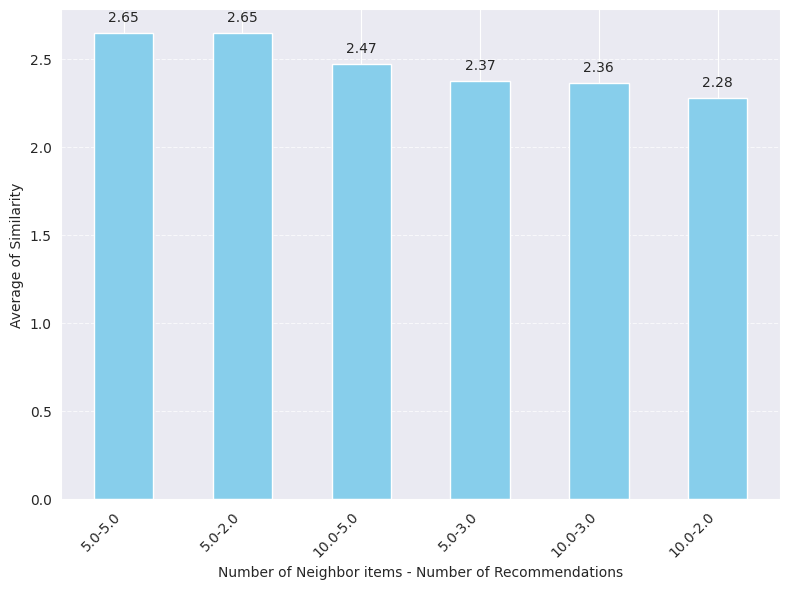

In [ ]:
df_sorted = df_combined.sort_values(by="Average of Similarity", ascending=False)

labels = [f"{row['Number of Neighbor items']}-{row['Number of Recommendations']}" for _, row in df_sorted.iterrows()]

plt.figure(figsize=(8, 6))
plt.bar(range(len(df_sorted)), df_sorted["Average of Similarity"], color='skyblue', width=0.5)
plt.xlabel('Number of Neighbor items - Number of Recommendations')
plt.ylabel('Average of Similarity')
plt.xticks(range(len(df_sorted)), labels, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, value in enumerate(df_sorted["Average of Similarity"]):
    plt.text(i, value + 0.05, round(value, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
result_1

[(292, 2.713559718757684), (1881, 2.5816010272282166)]

According to the above results, we decide to consider more neighbor items when we do the collaborative filtering. Compared to only selecting the top 3 similar items, we try to change it to 5 and 10. As depicted in the above bar chart, we can notice that when the `Number of Neighbor items` equals 5, the average similarity scores are higher than when it equals 10. Therefore, we tune the k-neighor to be 5.<br>
On the other hand, we also want to make sure that each of our recommendation would be liked by our users, so we decide to narrow down the `Number of Recommendations` and only return 2 most similar news to obtain a more pleasant reading experience for the News Website users.<br>
In conclusion, when we use Item-based CF, our sysytem would recommend news 292 and news 1881 to our user 2786, just as `result_1` shows above.